<a href="https://colab.research.google.com/github/melissaortegaa/monografia/blob/main/01_data_prep_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

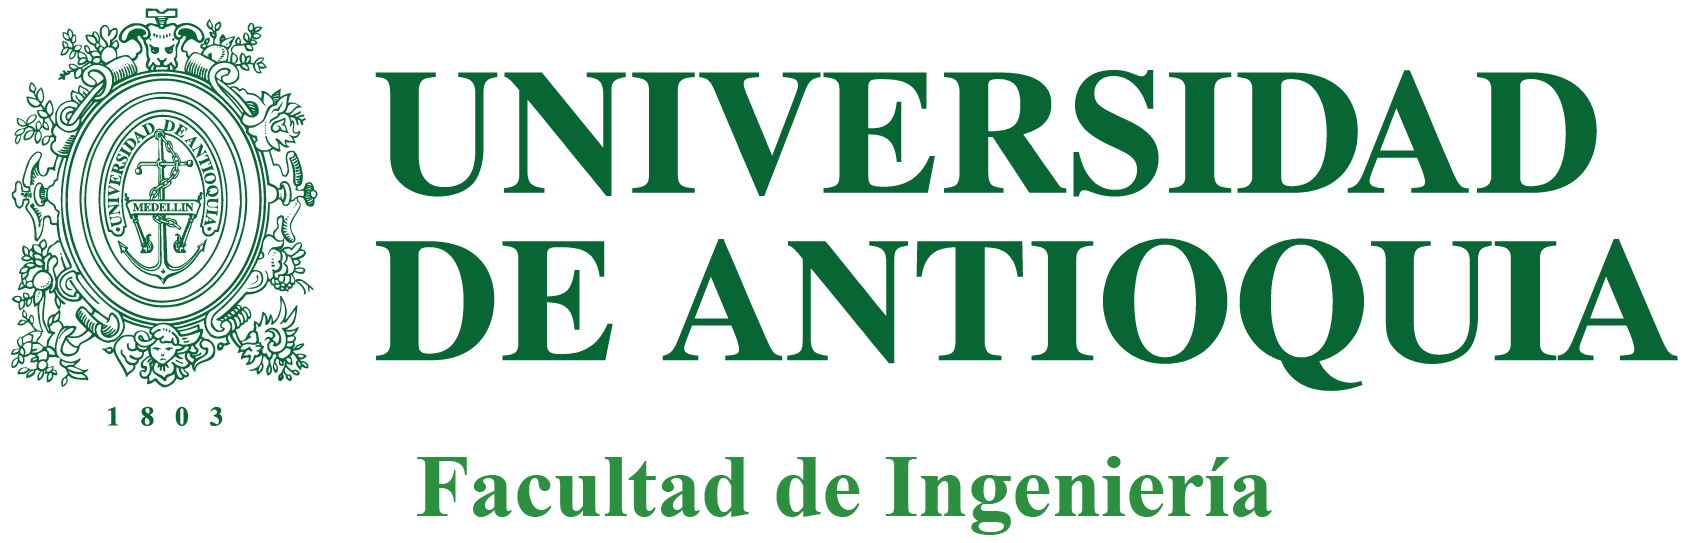
---

**Especialización en Analítica y Ciencia de Datos - Analytics & Data Science**

**Universidad de Antioquia**

**2024**

**Melissa Ortega Alzate**

---


# Exploración de Redes Neuronales Convolucionales para la detección de Salmonella *spp.* en aves de corral
### Exploration of Convolutional Neural Networks for the Detection of Salmonella spp. in Poultry

This notebook is the first  part of a series of four notebooks associated with the project "Exploration of Convolutional Neural Networks for the Detection of Salmonella spp. in Poultry". The other notebooks can be found in the associated GitHub repository linked below.

<div style="display: flex; align-items: center; justify-content: flex-end; position: fixed; bottom: 10px; right: 10px;">
  <a href="https://colab.research.google.com/github/tu-usuario/tu-repositorio" style="margin-right: 15px;">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" style="height: 25px;">
  </a>
  <a href="https://github.com/melissaortegaa/monografia" style="margin-right: 15px;">
    <img src="https://img.shields.io/badge/GitHub-000?logo=github&logoColor=fff&style=flat" alt="View on GitHub" style="height: 25px;">
  </a>
</div>

## Objective
Prepare a set of images and their labels for subsequent use in a Machine Learning algorithm, specifically Convolutional Neural Networks.

## Summary
In this script, a directory of images is built to obtain the file data.zip, which contains the images organized into training, test, and validation sets.Additionally, it includes an exploratory data analysis, which involves constructing a DataFrame with metadata of the images: their dimensions, aspect ratio, size, pixel range, etc. Moreover, it visualizes the distribution of images by class, some random images, and their aspect ratio.

# Libraries & Settings

In [1]:
# Standard library imports
import os
import random
import shutil
import zipfile
import glob

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")

# Data manipulation and processing
import numpy as np
import pandas as pd
import cv2

# Deep learning frameworks and utilities
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Warnings configuration
import warnings
warnings.filterwarnings('ignore')

# Functions

In [2]:
# Define function to copy files in a folder
def copy_files(archivos, new_folder):
    for archivo in archivos:
        origen = os.path.join(original_folder, archivo)
        destino = os.path.join(new_folder, archivo)
        shutil.copy(origen, destino)

In [3]:
# Funtion to plot images characteristics
def bar_plot(df, target_var, title):
  '''
    Returns the figure build from input parameters.
      Parameters:
              df          [dataframe]  Features dataframe.
              target_var  [string]     Name of column of target variable or feature.
              title       [string]     Title for figure

      Returns:
              Plot of figure
  '''
  fig, axes = plt.subplots(1, 1)
  ax_cond = axes
  sns.countplot(df,
                  x = target_var,
                  ax = axes,
                  palette = 'mako',
                  zorder = 2,
                  order = df[target_var].value_counts().index,
                  alpha = 0.8,
                  legend=False,
                  hue= target_var
                  )

  for bars in axes.containers:
    axes.bar_label(bars, fmt='%.0f',fontweight = "bold", color ='gray')

  # set seaborn plotting aesthetics
  axes.set_xticklabels(ax_cond.get_xticklabels())
  axes.tick_params(labelsize = 10)
  axes.set_xlabel("")
  fig.tight_layout()
  plt.subplots_adjust(top = 0.9)
  fig.suptitle(title, fontsize = 12);

In [4]:
# Function to plot images aspect ratio
def img_size(images_metadata):
  '''
    Returns the figure build from input parameters.

      Parameters:
              dataset (dataframe): data to be plotted.
              dataset_name (string): Name of dataset.

      Returns:
              Plot of figure
  '''
  #set seaborn plotting aesthetics
  sns.set(context="paper", style='whitegrid')

  org_data = images_metadata[images_metadata['label'] == 'healthy']
  rec_data = images_metadata[images_metadata['label'] == 'salmo']

  fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  plot = sns.scatterplot(data=org_data,
                  x="width",
                  y="height",
                  hue="aspect_ratio",
                  size="aspect_ratio",
                  sizes=(70, 350),
                  legend = False,
                  ax= axes[0],
                  palette = 'crest',
                  linewidth = 0.4)
  axes[0].set_title('images', fontsize=12)
  axes[0].set_ylabel('height')
  axes[0].set_xlabel('width')
  norm = plt.Normalize(images_metadata['aspect_ratio'].min(), images_metadata['aspect_ratio'].max())
  sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
  cbar = fig.colorbar(sm,ax=axes[0])
  cbar.set_label('Aspect_ratio', rotation=90)
  axes[0].set_title(f"Healthy data",fontsize=10)


  sns.scatterplot(data=rec_data,
                  x="width",
                  y="height",
                  hue="aspect_ratio",
                  size="aspect_ratio",
                  sizes=(70, 350),
                  legend = False,
                  ax= axes[1],
                  palette = 'crest',
                  linewidth = 0.4)
  axes[1].set_title('masks', fontsize=12)
  axes[1].set_ylabel('height')
  axes[1].set_xlabel('width')
  norm = plt.Normalize(rec_data['aspect_ratio'].min(), rec_data['aspect_ratio'].max())
  sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
  cbar = fig.colorbar(sm,ax=axes[1])
  cbar.set_label('aspect_ratio', rotation=90)
  axes[1].set_title(f"Salmonella data",fontsize=10)

  fig.tight_layout()
  fig.suptitle(f"Exploring images dimensions",
              fontsize=12,
              fontweight='bold',
              y=1.07)
  plt.show()

In [5]:
# Function to plot random images
def show_random_images(df, n_images):
  '''
  Returns a figure built from random images from the dataset.

    Parameters:
            df          [dataframe]  DataFrame with image paths and corresponding classes

    Returns:
            Plot of the figure
  '''

  # Get random images
  image_files = random.sample(df['path'].tolist(), n_images)
  fig, axes = plt.subplots(n_images//5, n_images//5, figsize=(10, 10))

  for i, ax in enumerate(axes.ravel()):
    image_file = image_files[i]
    class_name = df[df['path'] == image_file]['label'].values[0]

    # Load the image using matplotlib
    img = plt.imread(image_file)

    # Show the image in the subplot
    ax.imshow(img)

    # Define styles
    title_color = 'red' if class_name == 'salmo' else 'blue'
    ax.set_title(class_name, fontsize=8, color=title_color)
    ax.axis('off')

  plt.tight_layout()
  plt.show()

In [28]:
def plot_histograms(directory, category):
  # Calculate the average brightness, hue, and saturation of the images
  brightness_values = []
  hue_values = []
  saturation_values = []
  sns.set(context="paper", style='whitegrid')

  # Loop through the images in the directory
  for filename in os.listdir(directory):
      img_path = os.path.join(directory, filename)
      if os.path.isfile(img_path):  # Check if it's a file, not a directory
          image = cv2.imread(img_path)

          # Convert the image to different color spaces
          hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Calculate the average pixel intensities
          gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
          brightness = np.mean(gray)
          brightness_values.append(brightness)

          # Calculate the average hue value
          hue = np.mean(hsv_image[:, :, 0])
          hue_values.append(hue)

          # Calculate the average saturation value
          saturation = np.mean(hsv_image[:, :, 1])
          saturation_values.append(saturation)

  # Set the same range for the x-axis
  x_axis_range = (0, 255)

  # Display the histograms of hue, saturation, and brightness values
  plt.figure(figsize=(6, 5))
  n, bins, patches = plt.hist(hue_values, bins=30, range=x_axis_range, color='r', alpha=0.7, label='Hue')
  plt.hist(saturation_values, bins=30, range=x_axis_range, color='g', alpha=0.7, label='Saturation')
  plt.hist(brightness_values, bins=30, range=x_axis_range, color='b', alpha=0.7, label='Brightness')

  # Set the labels, title, and legend
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.xlim(0, 255)
  plt.ylim(0, 150)
  plt.title(f'Distribution of color properties - {category}', weight='bold')
  plt.legend()

  # Display the plot
  plt.show();

  # Create a DataFrame with hue, saturation, and brightness values
  df = pd.DataFrame({'Hue': hue_values,
                    'Saturation': saturation_values,
                    'Brightness': brightness_values})

  # Generate the summary statistics including skewness
  summary = round(df.describe(), 2)
  summary.loc['skewness'] = round(df.skew(), 2)

  # Display the statistics
  display(summary)

# Load the original data

In [7]:
# Download the zip file
!gdown '1EvNWxLmjgAaTYnP0WAUQEJP85RoktedD' -O \
   /tmp/data.zip

Downloading...
From (original): https://drive.google.com/uc?id=1EvNWxLmjgAaTYnP0WAUQEJP85RoktedD
From (redirected): https://drive.google.com/uc?id=1EvNWxLmjgAaTYnP0WAUQEJP85RoktedD&confirm=t&uuid=50e15f42-80fd-4b2d-a724-436b696f6e8e
To: /tmp/data.zip
100% 279M/279M [00:01<00:00, 146MB/s]


In [8]:
# Extract the files into tmp folder
local_zip = '/tmp/data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/original_data')
zip_ref.close()

In [9]:
# Set paths
original_folder = '/tmp/original_data/Train'
new_folder = '/tmp/data2'

# Verify the total number of images per class
healthy_files = [archivo for archivo in os.listdir(original_folder) if 'healthy' in archivo.lower()]
salmo_files =   [archivo for archivo in os.listdir(original_folder) if 'salmo' in archivo.lower()]

# Verify the total number of images per class
print('Total healthy images:', len(healthy_files))
print('Total salmo images:',   len(salmo_files))

Total healthy images: 2404
Total salmo images: 2625


# Split data into train, valid and test directory

In [10]:
# Set folders for 'train', 'validation' and 'test' images
os.makedirs(os.path.join(new_folder, 'train', 'healthy'), exist_ok=True)
os.makedirs(os.path.join(new_folder, 'train', 'salmo'), exist_ok=True)

os.makedirs(os.path.join(new_folder, 'validation', 'healthy'), exist_ok=True)
os.makedirs(os.path.join(new_folder, 'validation', 'salmo'), exist_ok=True)

os.makedirs(os.path.join(new_folder, 'test', 'healthy'), exist_ok=True)
os.makedirs(os.path.join(new_folder, 'test', 'salmo'), exist_ok=True)

In [11]:
classes = ['healthy', 'salmo']

for i in classes:
  # Define folder paths
  train_folder = os.path.join(new_folder, 'train', i)
  test_folder = os.path.join(new_folder, 'test', i)
  validation_folder = os.path.join(new_folder, 'validation', i)

  # Shuffle the files
  files = [archivo for archivo in os.listdir(original_folder) if i in archivo.lower()]
  random.shuffle(files)

  # Get train, test and valid proportions
  num_train = int(0.80 * len(files))
  num_validation = int(0.15 * len(files))
  num_test =len(files) - num_train - num_validation

  # Split the dataset into train, test and valid
  train_imgs = files[:num_train]
  validation_imgs = files[num_train:num_train + num_validation]
  test_imgs = files[num_train + num_validation:]

  # Copy the files into destiny folders
  copy_files(train_imgs, train_folder)
  copy_files(validation_imgs, validation_folder)
  copy_files(test_imgs, test_folder)


In [12]:
# Define new directory architecture
base_dir = '/tmp/data2'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Training directories
train_healthy_dir = os.path.join(train_dir, 'healthy')
train_salmo_dir = os.path.join(train_dir, 'salmo')

# Validation directories
validation_healthy_dir = os.path.join(validation_dir, 'healthy')
validation_salmo_dir = os.path.join(validation_dir, 'salmo')

# Test directories
test_healthy_dir = os.path.join(test_dir, 'healthy')
test_salmo_dir = os.path.join(test_dir, 'salmo')

# Lists of files in folders
train_healthy_fnames = os.listdir(train_healthy_dir)
train_salmo_fnames = os.listdir(train_salmo_dir)

test_healthy_fnames = os.listdir(test_healthy_dir)
test_salmo_fnames = os.listdir(test_salmo_dir)

validation_healthy_fnames = os.listdir(validation_healthy_dir)
validation_salmo_fnames = os.listdir(validation_salmo_dir)

In [13]:
# Verify the total number of images per class
print('Total healthy images:', len(os.listdir(train_healthy_dir)) + len(os.listdir(validation_healthy_dir)) + len(os.listdir(test_healthy_dir)))
print('Total salmo images:',   len(os.listdir(train_salmo_dir)) + len(os.listdir(validation_salmo_dir)) + len(os.listdir(test_salmo_dir)))

Total healthy images: 2404
Total salmo images: 2625


In [14]:
# Ruta de la carpeta que quieres comprimir
carpeta_a_comprimir = '/tmp/data2'

# Ruta del archivo ZIP de salida
zip_file = '/tmp/data_new.zip'

# Comprimir la carpeta en un archivo ZIP
with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(carpeta_a_comprimir):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), carpeta_a_comprimir))

# Exploratory Data Analysis

### Labels

In [15]:
# Define data location
data_dir = 'data/'
labels_url = 'https://raw.githubusercontent.com/melissaortegaa/monografia/main/labels.csv'

# Read the file with the labels
df = pd.read_csv(labels_url)

# Preliminary view of the file with the labels
df.head(5)

,images,label
0,salmo.1558.jpg,Salmonella
1,cocci.1866.jpg,Coccidiosis
2,cocci.171.jpg,Coccidiosis
3,salmo.1484.jpg,Salmonella
4,ncd.100.jpg,New Castle Disease


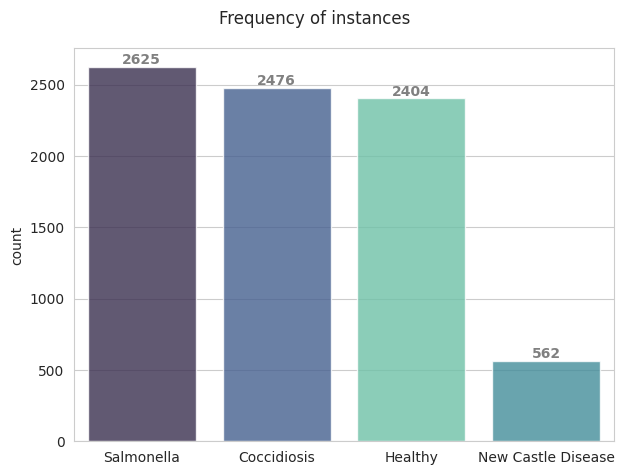

In [16]:
# Visualize the frequency of instances
bar_plot(df, 'label', 'Frequency of instances')

In [17]:
# Check nulls, data types, and file size
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8067 entries, 0 to 8066
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  8067 non-null   object
 1   label   8067 non-null   object
dtypes: object(2)
memory usage: 126.2+ KB


## Images

In [18]:
images_metadata = []

# Ensure paths contain directories with image files
image_directories = [test_healthy_dir, test_salmo_dir, train_healthy_dir, train_salmo_dir, validation_healthy_dir,validation_salmo_dir ]

for directory in image_directories:
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        if os.path.isfile(img_path):  # Check if it's a file, not a directory
            img = mpimg.imread(img_path)
            category = directory.split('/')[-1]
            shape = img.shape
            images_metadata.append({
                'path': img_path,
                'label': category,
                'height': shape[0],
                'width': shape[1],
                'aspect_ratio': shape[0] / shape[1],
                'size' : shape[0] * shape[1],
                'channels' : shape[2],
                'dtype' : img.dtype,
                'pixel_range': f"{img.min()} - {img.max()}"
             })

images_metadata = pd.DataFrame(images_metadata)
images_metadata.head(10)

,path,label,height,width,aspect_ratio,size,channels,dtype,pixel_range
0,/tmp/data2/test/healthy/pcrhealthy.130.jpg,healthy,224,224,1.0,50176,3,uint8,25 - 235
1,/tmp/data2/test/healthy/pcrhealthy.29.jpg,healthy,224,224,1.0,50176,3,uint8,0 - 255
2,/tmp/data2/test/healthy/healthy.1419.jpg,healthy,224,224,1.0,50176,3,uint8,1 - 255
3,/tmp/data2/test/healthy/healthy.279.jpg,healthy,224,224,1.0,50176,3,uint8,8 - 255
4,/tmp/data2/test/healthy/healthy.955.jpg,healthy,224,224,1.0,50176,3,uint8,36 - 243
5,/tmp/data2/test/healthy/healthy.169.jpg,healthy,224,224,1.0,50176,3,uint8,10 - 240
6,/tmp/data2/test/healthy/healthy.960.jpg,healthy,224,224,1.0,50176,3,uint8,25 - 255
7,/tmp/data2/test/healthy/healthy.2029.jpg,healthy,224,224,1.0,50176,3,uint8,21 - 253
8,/tmp/data2/test/healthy/healthy.1776.jpg,healthy,224,224,1.0,50176,3,uint8,1 - 255
9,/tmp/data2/test/healthy/healthy.901.jpg,healthy,224,224,1.0,50176,3,uint8,48 - 255


In [19]:
# Check nulls, data types, and file size
images_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   path          5029 non-null   object 
 1   label         5029 non-null   object 
 2   height        5029 non-null   int64  
 3   width         5029 non-null   int64  
 4   aspect_ratio  5029 non-null   float64
 5   size          5029 non-null   int64  
 6   channels      5029 non-null   int64  
 7   dtype         5029 non-null   object 
 8   pixel_range   5029 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 353.7+ KB


In [20]:
# Check duplicated
df.loc[df.duplicated()]

,images,label


No existen registros duplicados en el archivo con las etiquetas.

# Data visualization

En total, el dataset tiene 2529 imágenes. A continuación, se visualiza cómo está dividido:

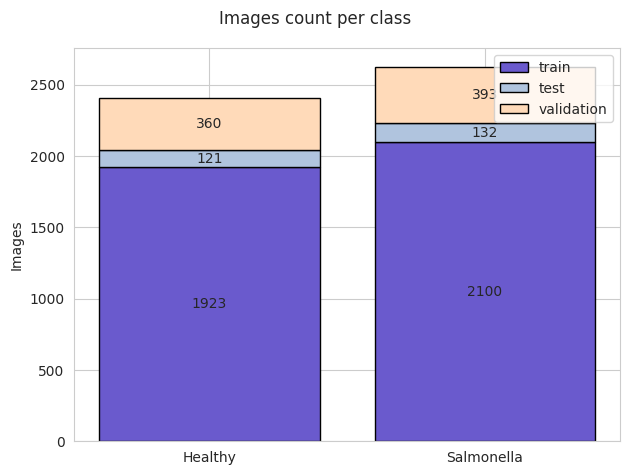

In [21]:
# Plot dataset size and distribution
fig, axes = plt.subplots()
x = np.arange(2)

train = [len(train_healthy_fnames), len(train_salmo_fnames)]
test = [len(test_healthy_fnames), len(test_salmo_fnames)]
validation = [len(validation_healthy_fnames), len(validation_salmo_fnames)]

p1 = axes.bar(x, train, color='slateblue', edgecolor='black')
p2 = axes.bar(x, test, bottom=train, color='lightsteelblue', edgecolor='black')
p3 = axes.bar(x, validation, bottom=np.array(train) + np.array(test), color='peachpuff', edgecolor='black')

plt.ylabel('Images')

# Set the positions and labels for the ticks
plt.xticks(x, ('Healthy', 'Salmonella'), ha='center')
plt.legend((p1[0], p2[0], p3[0]), ('train', 'test', 'validation'), loc='upper right')

for bars in axes.containers:
    axes.bar_label(bars, fmt='%.0f', label_type='center')

fig.suptitle("Images count per class", fontsize=12)
plt.tight_layout()
fig.set_facecolor('white')
plt.show();

Se observa que la variable objetivo presenta dos categorías muy equilibradas. Por lo tanto, el data set está balanceado con un 52,1 % de los registros en la categoría "Salmonella" vs 47,9 % para "Healthy", representando aquellas imágenes que fueron confirmadas con presencia del microorganismo patógeno Salmonella spp. y las que no, respectivamente.

Ahora, se visualizan algunas imágenes de muestra:

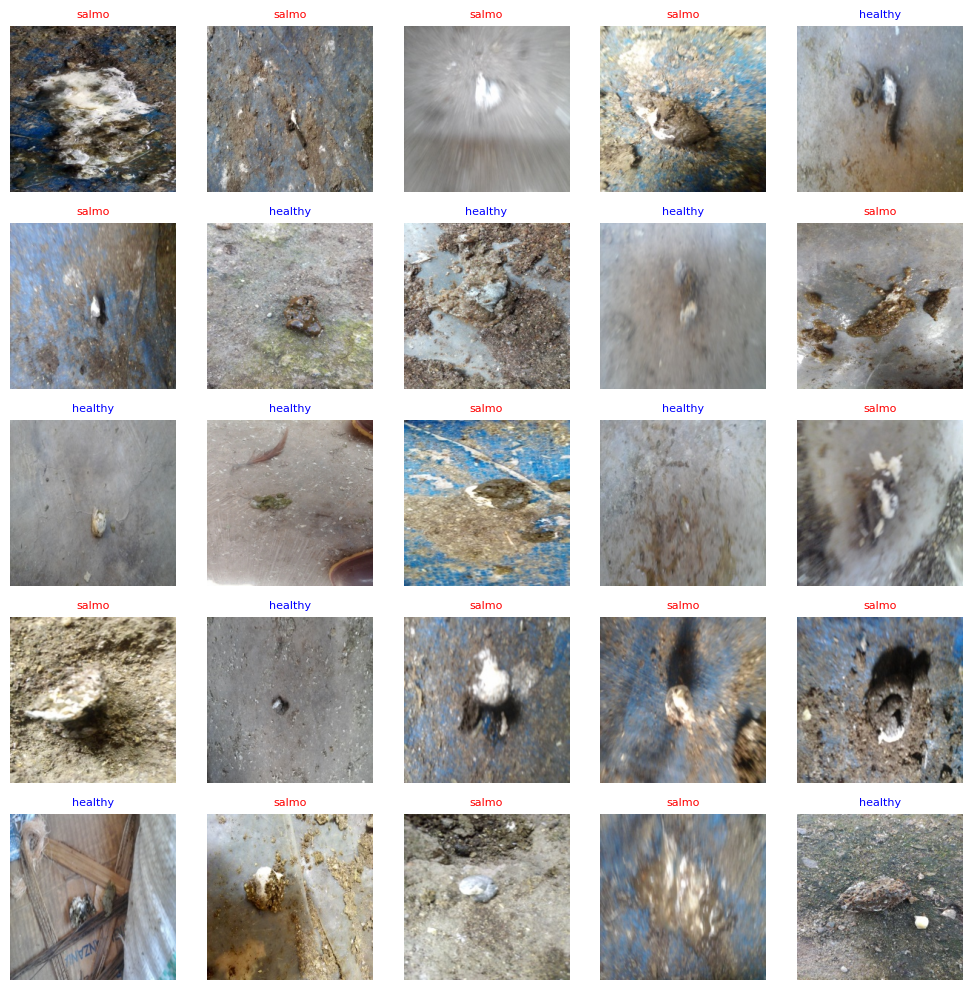

In [22]:
# Using the function to visualize random images and their classes
show_random_images(images_metadata, 25)

Al ejecutar la celda que presenta las imágenes aleatorias, se han evidenciado algunas figuras borrosas y oscuras. Además, el entorno en donde fue tomada la fotografía de las heces es muy variado. Es importante considerar realizar un zoom a las imágenes en donde se pueda mantener las heces y restar detalles alrededor que puedan comprometer el desempeño del modelo de clasificación a entrenar.

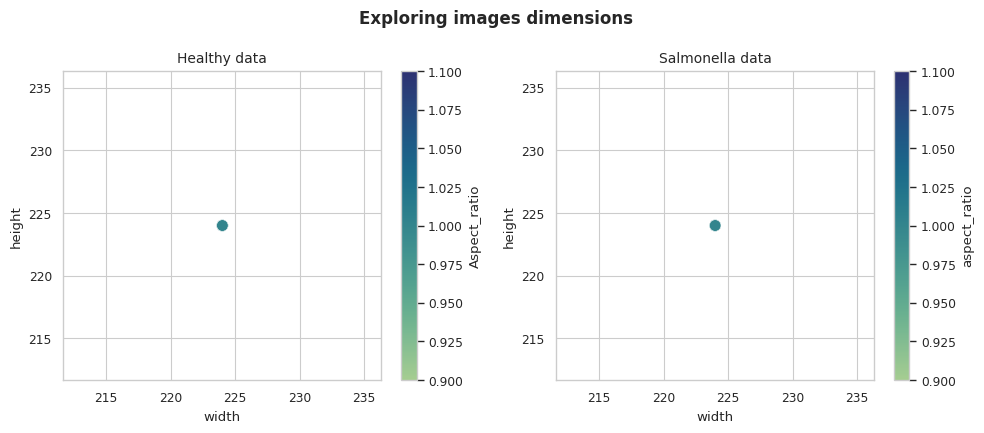

In [23]:
# Plot the figure using the builded function
img_size(images_metadata)

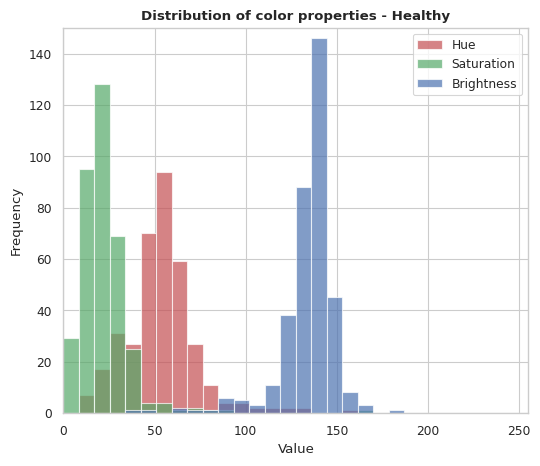

,Hue,Saturation,Brightness
count,360.00,360.00,360.00
mean,53.59,22.08,134.14
std,19.45,13.69,15.51
min,9.81,4.91,39.51
25%,44.12,14.40,130.64
50%,52.78,19.95,137.47
75%,62.38,26.92,141.68
max,158.31,165.44,185.76
skewness,1.11,4.20,-2.40


In [29]:
# Define the directory with the images
plot_histograms(validation_healthy_dir, category='Healthy')

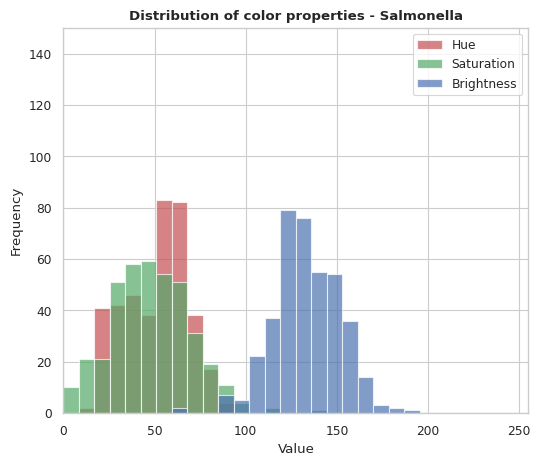

,Hue,Saturation,Brightness
count,393.00,393.00,393.00
mean,50.82,48.21,133.22
std,17.55,21.41,18.07
min,14.11,5.67,60.51
25%,36.42,33.46,122.59
50%,54.46,47.60,131.91
75%,63.72,62.46,146.53
max,92.15,140.11,189.05
skewness,-0.22,0.35,-0.19


In [30]:
# Define the directory with the images
plot_histograms(validation_salmo_dir, category='Salmonella')